In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
import seaborn as sns
import matplotlib.pyplot as plt
from genealogy_aligner.Aligner import DescMatchingAligner
from genealogy_aligner.Drawing import draw_interactive
from genealogy_aligner.ARG import ARG
import msprime as msp
import io
from IPython.display import SVG, display

Text(0.5, 1.0, 'Coalescent tree (diploid)')

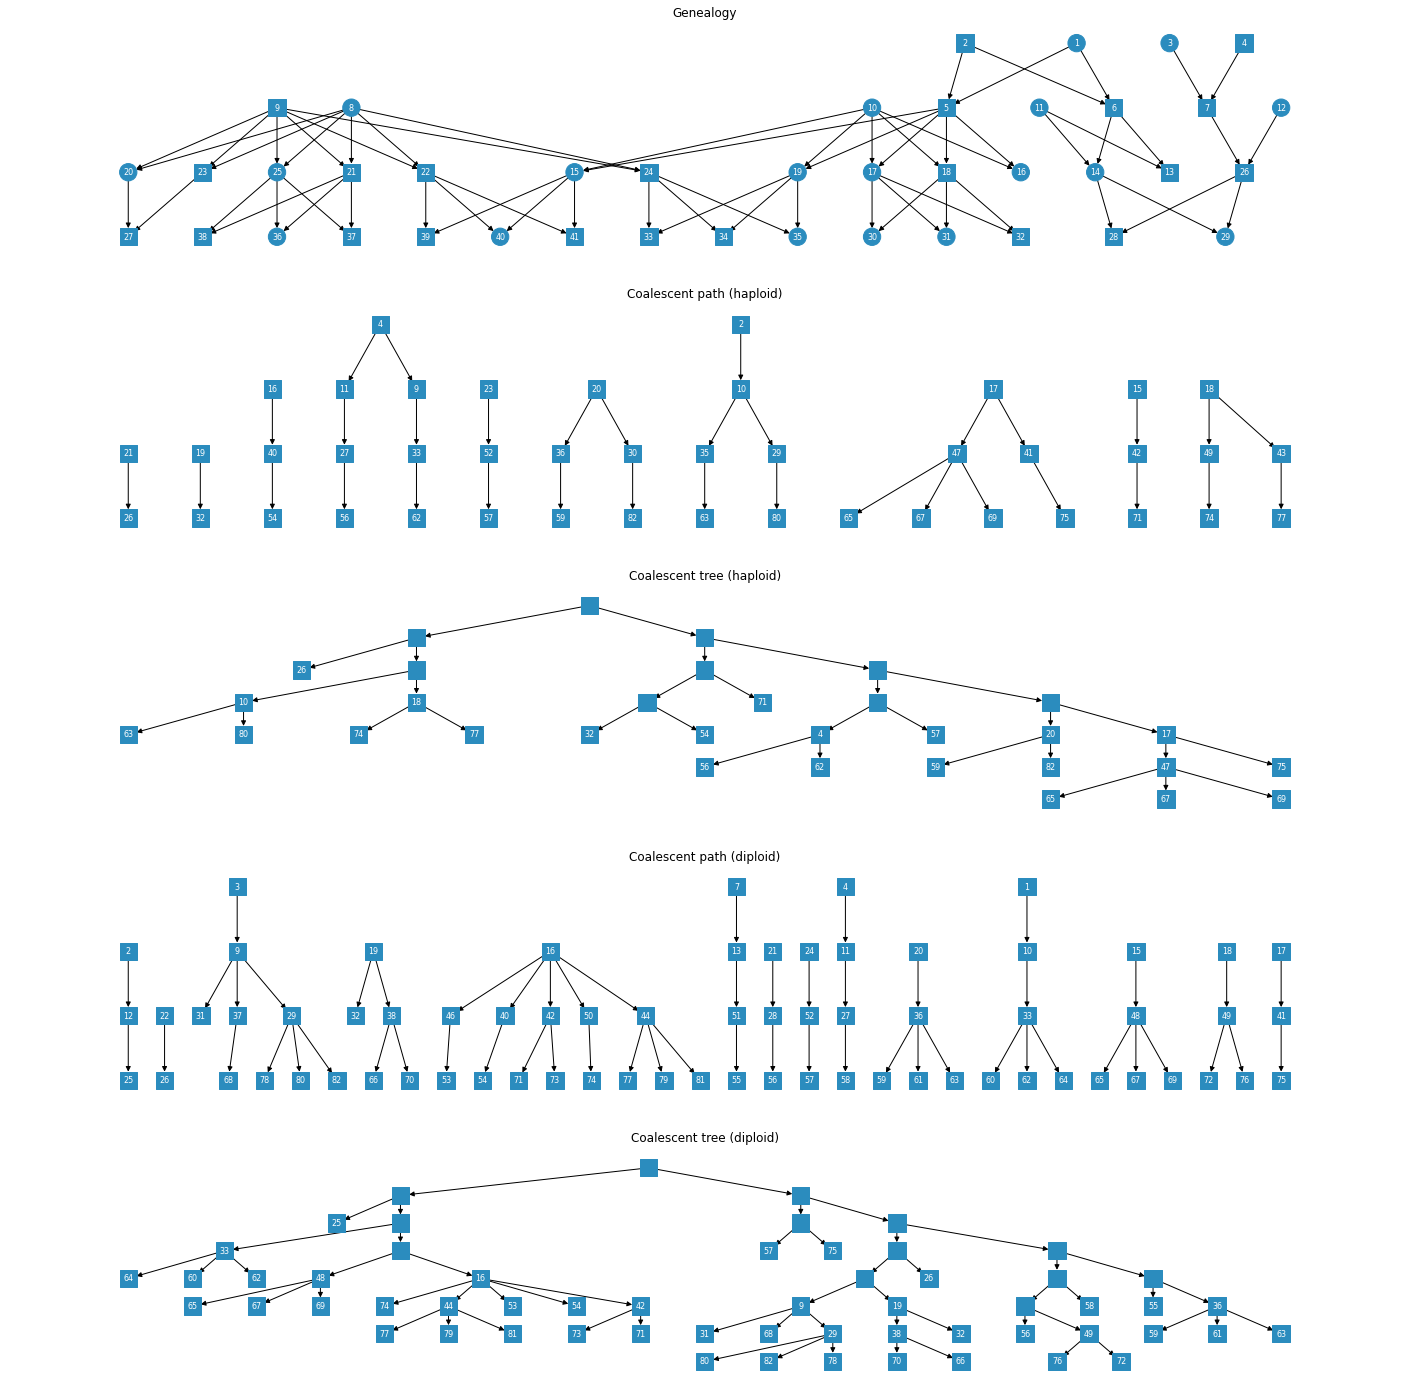

In [2]:
np.random.seed(724)

families = 3
generations = 3
avg_children = 2.2

ped = Pedigree.simulate_from_founders_with_sex(families, generations, avg_children)
h_graph = ped.get_haplotype_graph()

pt_1 = h_graph.sample_path(haploid_probands=True)
ct_1 = pt_1.to_coalescent_tree()

pt_2 = h_graph.sample_path()
ct_2 = pt_2.to_coalescent_tree()

fig, ax = plt.subplots(nrows=5, figsize=(25, 25))

ped.draw(ax=ax[0])
ax[0].set_title('Genealogy')

pt_1.draw(ax=ax[1], label_dict=pt_1.ts_node_to_ped_node)
ax[1].set_title('Coalescent path (haploid)')
ct_1.draw(ax=ax[2], label_dict=ct_1.ts_node_to_ped_node)
ax[2].set_title('Coalescent tree (haploid)')

pt_2.draw(ax=ax[3], label_dict=pt_2.ts_node_to_ped_node)
ax[3].set_title('Coalescent path (diploid)')
ct_2.draw(ax=ax[4], label_dict=ct_2.ts_node_to_ped_node)
ax[4].set_title('Coalescent tree (diploid)')

{'Node-Node Matching Accuracy': 0.8518518518518519, 'Proportion of Simple Symmetries': 0.0, 'Node-Edge Matching Accuracy': 0.07692307692307693}


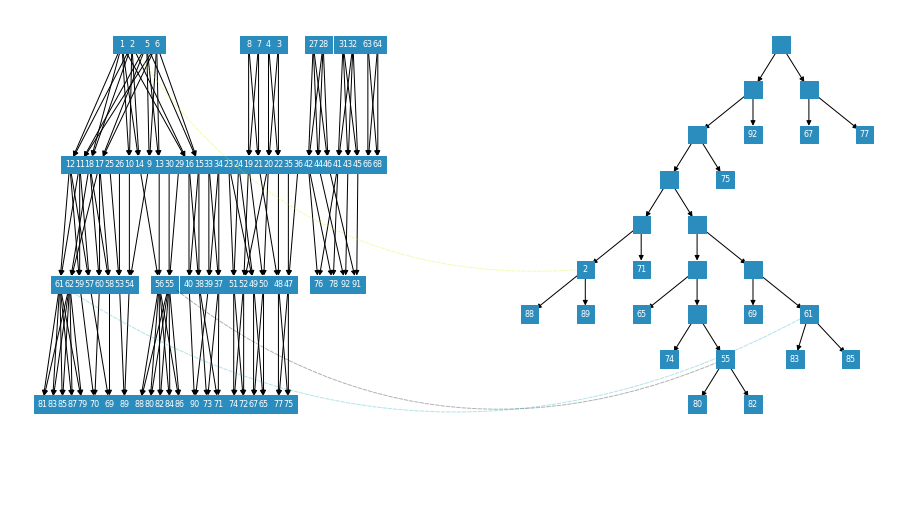

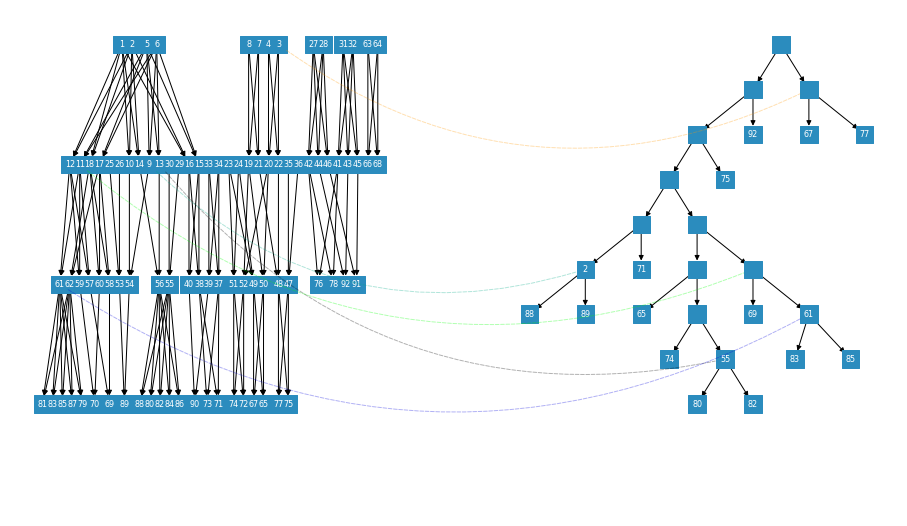

In [18]:
algn = DescMatchingAligner(h_graph, ct_1)
algn.align()
algn.complete_paths()
print(algn.evaluate()) # evaluate accuracy
# draw true vs. predicted
algn.draw()
plt.show()
algn.draw(use_predicted=True)

{'Node-Node Matching Accuracy': 0.8163265306122449, 'Proportion of Simple Symmetries': 0.3333333333333333, 'Node-Edge Matching Accuracy': 0.0625}


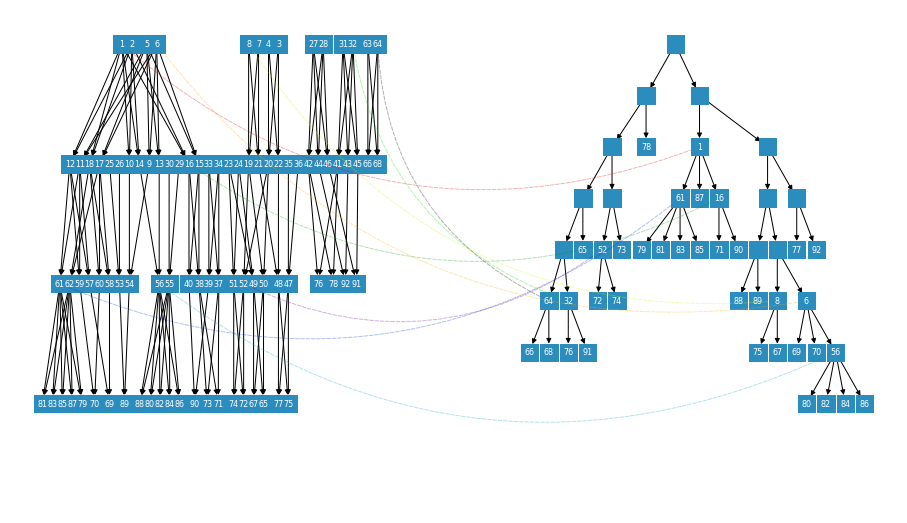

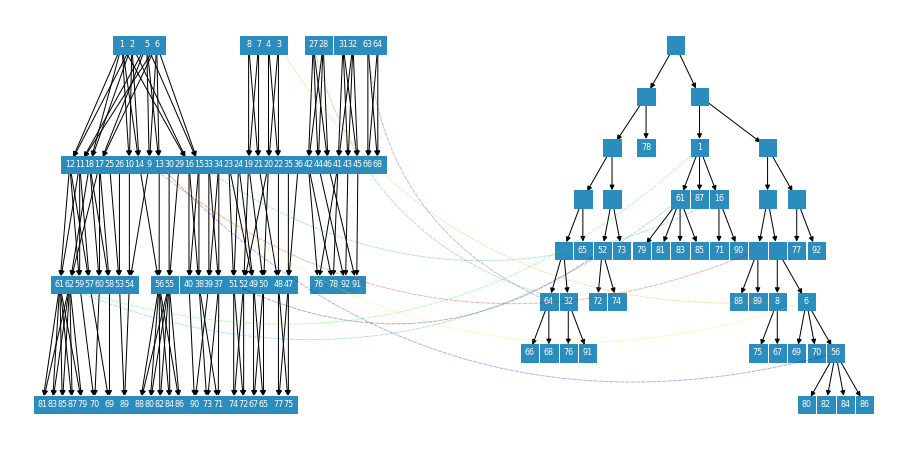

In [19]:
algn = DescMatchingAligner(h_graph, ct_2)
algn.align()
algn.complete_paths()
print(algn.evaluate()) # evaluate accuracy
# draw true vs. predicted
algn.draw()
plt.show()
algn.draw(use_predicted=True)

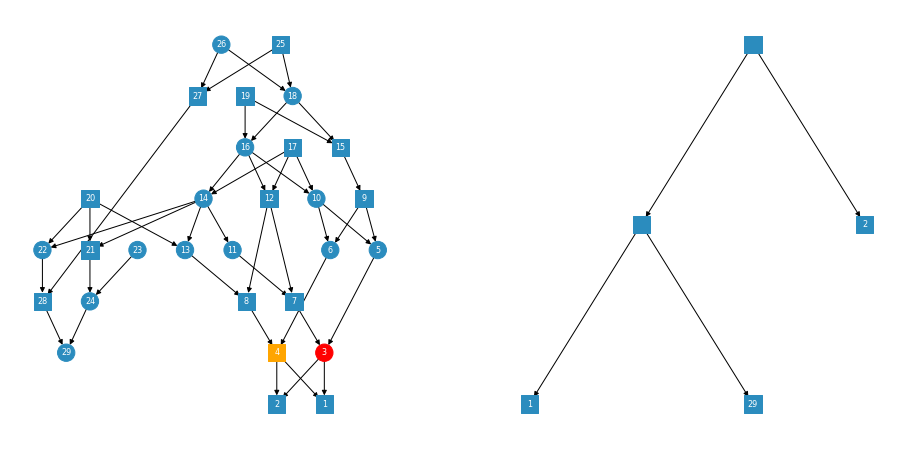

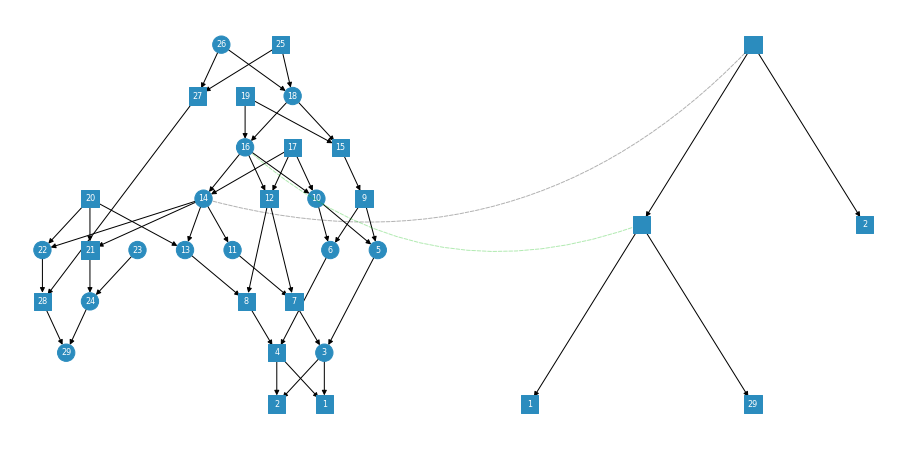

In [6]:
ped = Pedigree.from_table("../data/geneaJi.tsv", header=True, check_2_parents=False)
t = ped.sample_path()
ct = t.to_coalescent_tree()

algn = DescMatchingAligner(ped, ct)
algn.align()
algn.evaluate()

algn.draw(ped_kwargs={'node_color':{3: 'red', 4:'orange'}})
plt.show()
plt.close()
algn.draw(use_predicted=True)
plt.show()

In [8]:
draw_interactive(ped)

Text(value='', description='Node subset:', placeholder='List of nodes (comma separated)')

Text(value='1', description='Radius', placeholder='1')

Button(description='Plot', style=ButtonStyle())

Output()

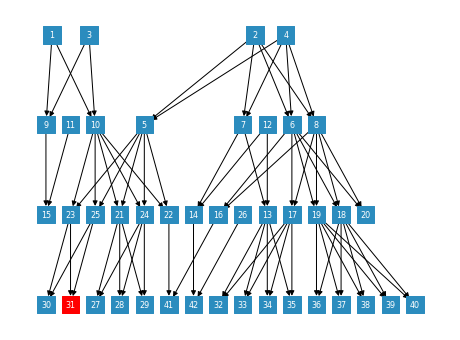

{23: {31: 1},
 25: {31: 1},
 10: {31: 2},
 5: {31: 2},
 1: {31: 2},
 2: {31: 2},
 3: {31: 2},
 4: {31: 2}}

In [119]:
ped.draw(node_color={31: 'red'})
plt.show()
ped.get_num_paths_to_target(31, include_target=False)

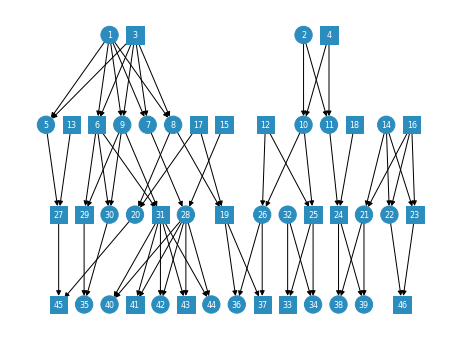

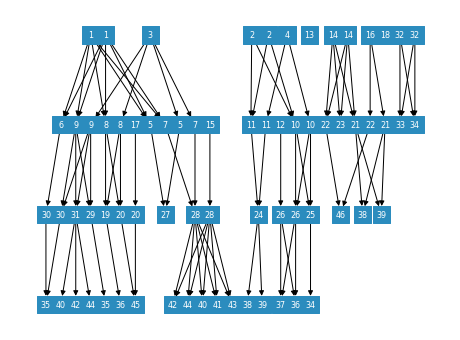

In [23]:
ped.draw()
plt.show()
x_graph = ped.get_haplotype_graph("X")
x_graph.draw(label_dict=x_graph.get_node_attributes('individual'))
plt.show()

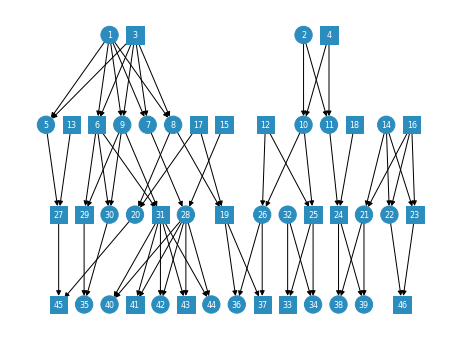

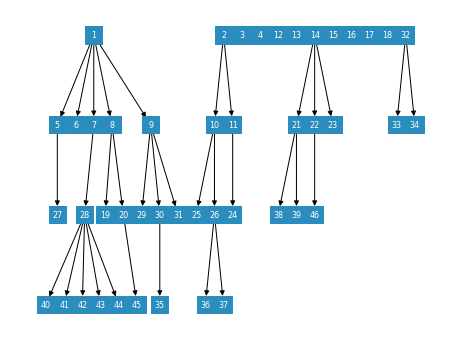

In [24]:
ped.draw()
plt.show()
mito_graph = ped.get_haplotype_graph("mitochondrial")
mito_graph.draw(label_dict=mito_graph.get_node_attributes('individual'))
plt.show()

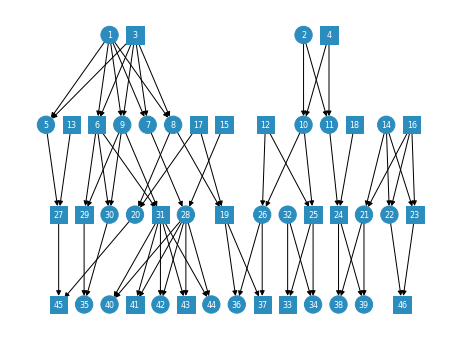

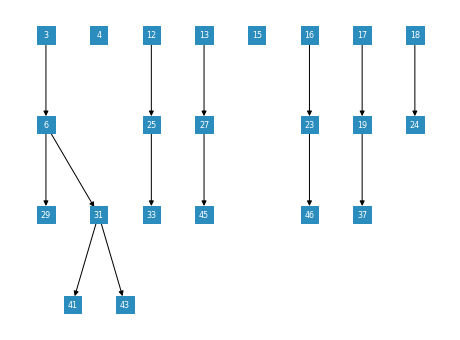

In [25]:
ped.draw()
plt.show()
y_graph = ped.get_haplotype_graph("Y")
y_graph.draw(label_dict=y_graph.get_node_attributes('individual'))
plt.show()

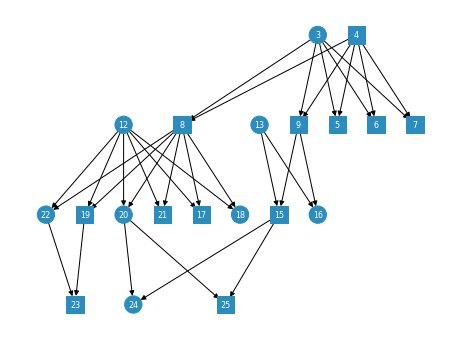

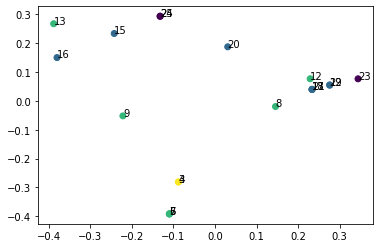

In [86]:
import scipy
G= ped.graph.to_undirected()

A = nx.adjacency_matrix(G)
a_shape = A.shape
a_diagonals = A.sum(axis=1)
D = scipy.sparse.spdiags(a_diagonals.flatten(),
                         [0],
                         a_shape[0],
                         a_shape[1],
                         format='csr')

L = (D - A)
# w are the eigenvalues
# v are the eigenvectors
w, v = scipy.linalg.eigh(L.todense())
x = v[:,1]
y = v[:,2]
ns = list(G.nodes())
spectral_coordinates = {ns[i] : [x[i], y[i]] for i in range(len(x))}
gen = [ped.get_node_attributes('time', n) for n in ns]

ped.draw()
plt.show()

fig, ax = plt.subplots()
ax.scatter(x, y, c=gen)

for txt, coord in spectral_coordinates.items():
    ax.annotate(txt, coord)

plt.show()

In [82]:
v.shape

(20, 20)

100%|██████████| 20/20 [00:00<00:00, 6896.82it/s]


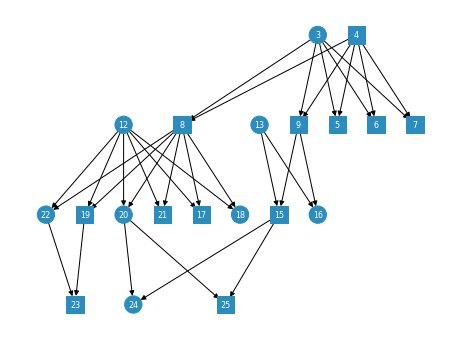

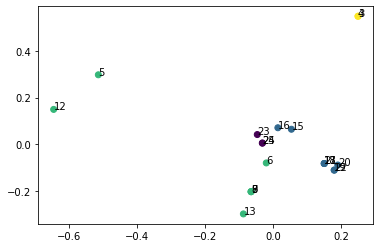

In [84]:
L = ped.kinship_lange()[0]

w, v = scipy.linalg.eigh(L)
x = v[:,0]
y = v[:,1]
ns = list(G.nodes())
kinship_coordinates = {ns[i] : [x[i], y[i]] for i in range(len(x))}
gen = [ped.get_node_attributes('time', n) for n in ns]

ped.draw()
plt.show()

fig, ax = plt.subplots()
ax.scatter(x, y, c=gen)

for txt, coord in kinship_coordinates.items():
    ax.annotate(txt, coord)

plt.show()

In [38]:
h_graph.get_node_attributes('time', 5)

2

In [142]:
def decompose_genealogical_object(obj, matrix='Laplace', x_idx=1, y_idx= 2, 
                                  labels=None, groupby_labels=False):
    
    if matrix == 'Laplace':
        
        obj_graph = obj.graph.to_undirected()

        A = nx.adjacency_matrix(obj_graph)
        a_shape = A.shape
        a_diagonals = A.sum(axis=1)
        D = scipy.sparse.spdiags(a_diagonals.flatten(),
                                 [0],
                                 a_shape[0],
                                 a_shape[1],
                                 format='csr')

        mat = (D - A).todense()
    elif matrix == 'Kinship':
        mat = obj.kinship_lange()[0]
    else:
        raise KeyError(f'Matrix {matrix} is not currently implemented.')
    
    w, v = scipy.linalg.eigh(mat)
    
    df = pd.DataFrame({
        'node': list(obj.nodes),
        'x': v[:, x_idx],
        'y': v[:, y_idx]
    })
    
    if labels is not None:
        df['label'] = [labels[n] for n in obj.nodes]
    
    if groupby_labels:
        df = df.groupby('label', as_index=False).mean()
    
    if groupby_labels and labels is not None:
        obj.draw(label_dict=labels)
    else:
        obj.draw()
        
    plt.show()

    fig, ax = plt.subplots()
    ax.scatter(df['x'], df['y'])

    for _, row in df.iterrows():
        if labels is not None:
            ax.annotate(row['label'], (row['x'], row['y']))
        else:
            ax.annotate(row['node'], (row['x'], row['y']))
    
    plt.show()
    

def decompose_graph_mat(mat, nodes, x_idx=1, y_idx=2):

    w, v = scipy.linalg.eigh(mat)
    
    df = pd.DataFrame({
        'node': nodes,
        'x': v[:, x_idx],
        'y': v[:, y_idx]
    })

    fig, ax = plt.subplots()
    ax.scatter(df['x'], df['y'])

    for _, row in df.iterrows():
        ax.annotate(row['node'], (row['x'], row['y']))
    
    plt.show()
    

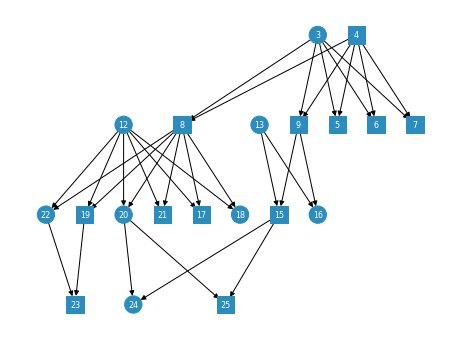

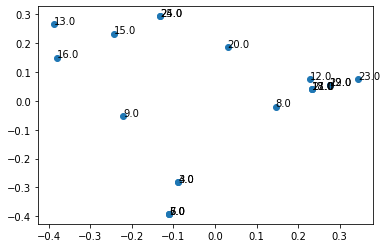

100%|██████████| 20/20 [00:00<00:00, 5016.21it/s]


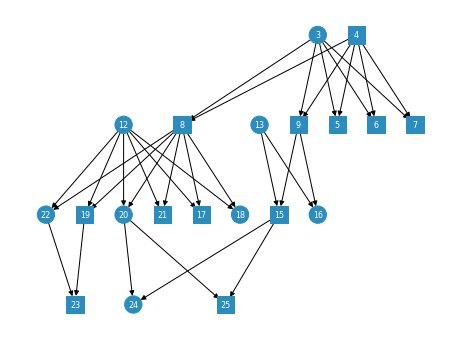

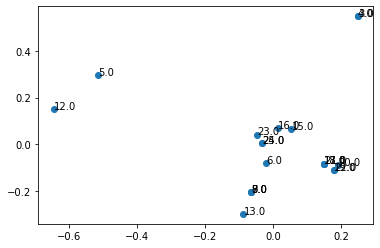

In [151]:
decompose_genealogical_object(ped)
decompose_genealogical_object(ped, matrix='Kinship', x_idx=0, y_idx=1)

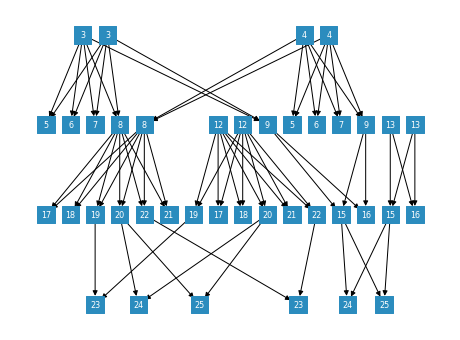

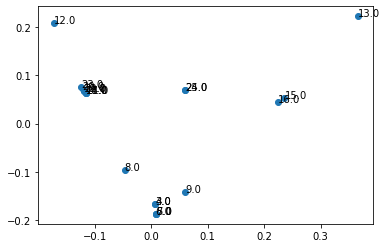

In [99]:
decompose_genealogical_object(h_graph, labels=h_graph.get_node_attributes('individual'), groupby_labels=True)

0
1
2


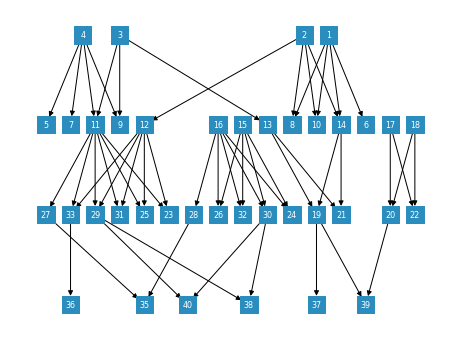

In [119]:
trs = [h_graph.sample_path() for _ in range(3)]

arg = ARG(trs)

arg.draw()

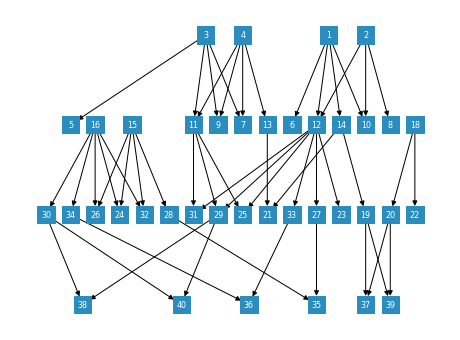

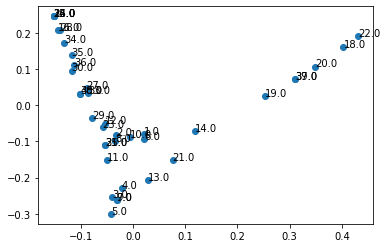

In [115]:
decompose_genealogical_object(arg)

0
1
2


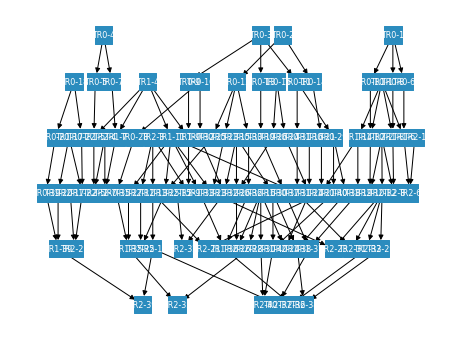

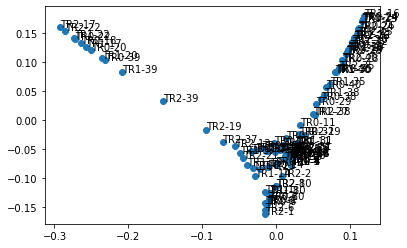

In [122]:
arg.set_graph_type('fused')
decompose_genealogical_object(arg)

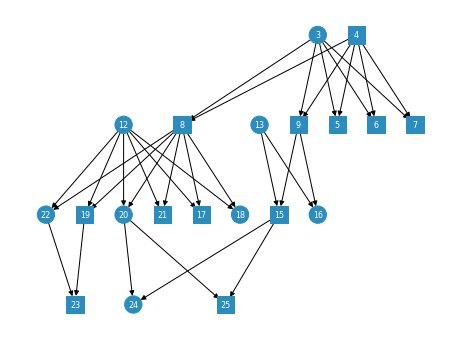

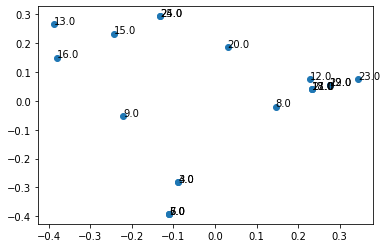

In [106]:
decompose_genealogical_object(ped)

In [117]:
li = [1, 2, 3]
li2 = li.copy()
li.append(5)
li, li2

([1, 2, 3, 5], [1, 2, 3])

laplacian


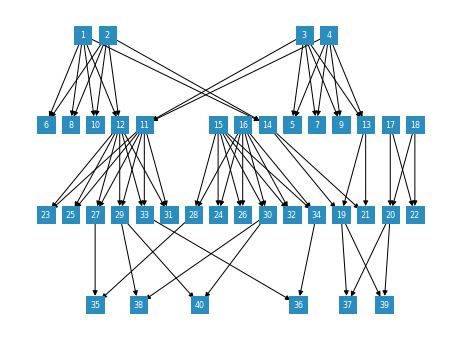

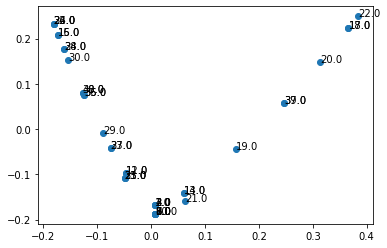

normalized_laplacian


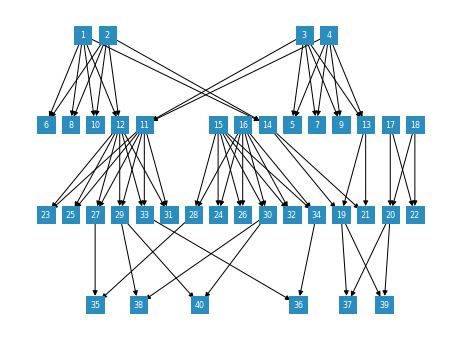

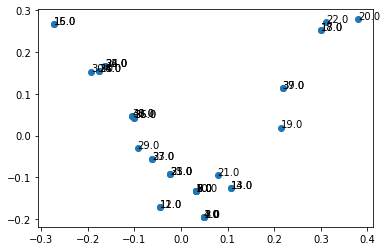

directed_laplacian


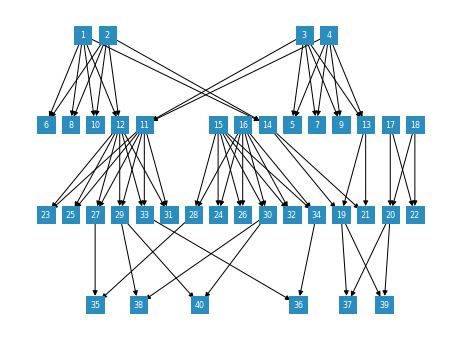

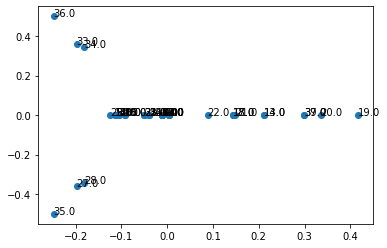

directed_combinatorial_laplacian


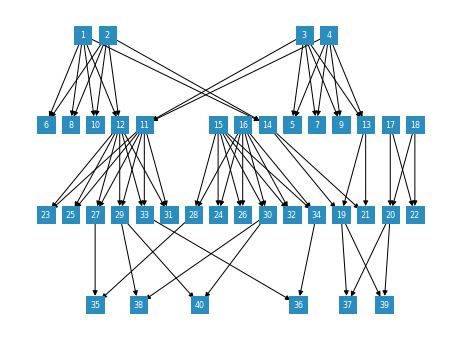

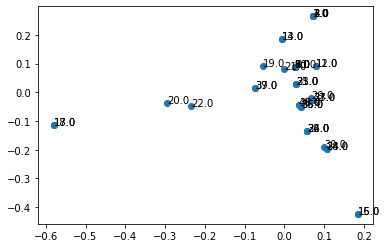

bethe_hessian


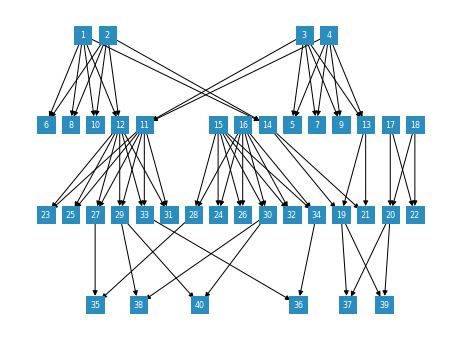

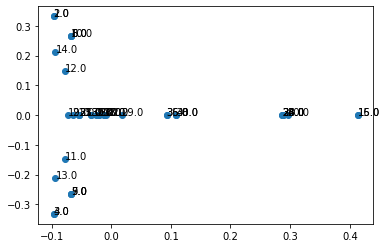

directed_modularity


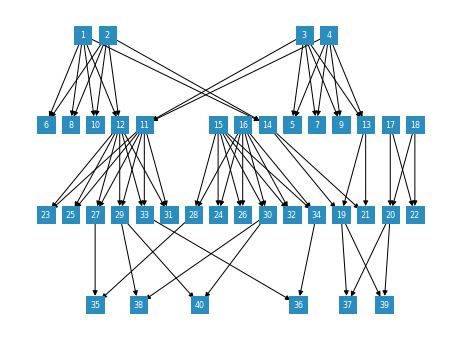

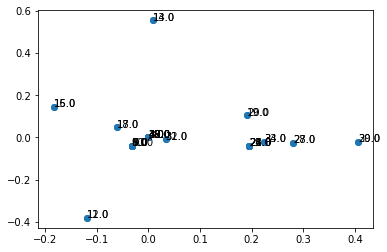

In [150]:
data_obj = h_graph

for mat_type in ['laplacian', 'normalized_laplacian', 'directed_laplacian',
                'directed_combinatorial_laplacian', 'bethe_hessian',
                'directed_modularity']:

    print(mat_type)
    data_obj.draw()
    
    if mat_type == 'laplacian':
        decompose_graph_mat(
            nx.linalg.laplacian_matrix(data_obj.graph.to_undirected()).todense(),
            data_obj.nodes
        )
    elif mat_type == 'normalized_laplacian':
        decompose_graph_mat(
            nx.linalg.normalized_laplacian_matrix(data_obj.graph.to_undirected()).todense(),
            data_obj.nodes
        )
    elif mat_type == 'directed_laplacian':
        decompose_graph_mat(
            nx.linalg.directed_laplacian_matrix(data_obj.graph),
            data_obj.nodes
        )
    elif mat_type == 'directed_combinatorial_laplacian':
        decompose_graph_mat(
            nx.linalg.directed_combinatorial_laplacian_matrix(data_obj.graph),
            data_obj.nodes
        )
    elif mat_type == 'bethe_hessian':
        decompose_graph_mat(
            nx.linalg.bethe_hessian_matrix(data_obj.graph.to_undirected()).todense(),
            data_obj.nodes
        )
    elif mat_type == 'directed_modularity':
        decompose_graph_mat(
            nx.linalg.directed_modularity_matrix(data_obj.graph),
            data_obj.nodes
        )

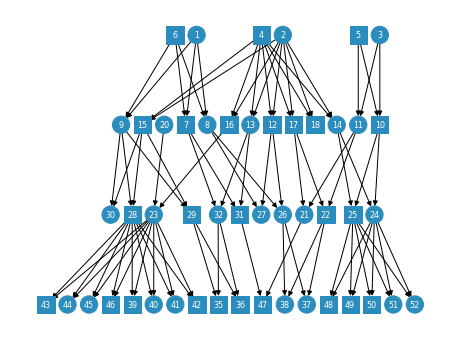

In [321]:
ped.draw()

In [345]:
mit_graph = ped.get_haplotype_graph('mitochondrial')

pd.DataFrame(mit_graph.kinship().toarray(),
             index=ped.nodes, columns=ped.nodes).values

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.]])

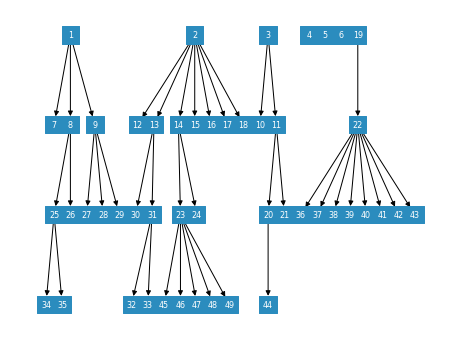

In [335]:
mit_graph.draw()

In [4]:
np.random.seed(555)

ped = Pedigree.simulate_from_founders_with_sex(10, 4, 2.2)
ped.n_individuals

156

In [7]:
%timeit ped.kinship_lange(progress=False)

131 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
h_graph = ped.get_haplotype_graph()

173 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit h_graph.kinship()

172 ms ± 620 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2]:
np.random.seed(555)

ped = Pedigree.simulate_from_founders_with_sex(100, 8, 3)
ped.n_individuals

12801

In [23]:
%time ped.kinship_lange(progress=False)

CPU times: user 10min 49s, sys: 874 ms, total: 10min 50s
Wall time: 10min 50s


(array([[0.5       , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.5       , 0.        , ..., 0.00195312, 0.00195312,
         0.00195312],
        [0.        , 0.        , 0.5       , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.00195312, 0.        , ..., 0.50939941, 0.26104736,
         0.26104736],
        [0.        , 0.00195312, 0.        , ..., 0.26104736, 0.50939941,
         0.26104736],
        [0.        , 0.00195312, 0.        , ..., 0.26104736, 0.26104736,
         0.50939941]]),
 {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  11: 10,
  12: 11,
  13: 12,
  14: 13,
  15: 14,
  16: 15,
  17: 16,
  18: 17,
  19: 18,
  20: 19,
  21: 20,
  22: 21,
  23: 22,
  24: 23,
  25: 24,
  26: 25,
  27: 26,
  28: 27,
  29: 28,
  30: 29,
  31: 30,
  32: 31,
  33: 32,
  34: 33,
  35: 34,
  36: 35,
  37: 36,
  38: 37,
  39: 38,
  40: 39,
  41: 40,
  42: 41,
  43: 42

In [3]:
%time h_graph = ped.get_haplotype_graph()

CPU times: user 510 ms, sys: 17.6 ms, total: 527 ms
Wall time: 527 ms


In [71]:
%time h_graph = ped.get_haplotype_graph('mitochondrial')

CPU times: user 224 ms, sys: 4.83 ms, total: 229 ms
Wall time: 228 ms


In [4]:
%time h_graph.kinship(individual_level=False, to_csr=False)

> inferring depth 2020-08-13 03:28:35.772559
> sorting nodes 2020-08-13 03:28:35.897510
> backward pass 2020-08-13 03:28:35.900083


/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


KeyboardInterrupt: 

In [68]:
test_ped = Pedigree.simulate_from_founders_with_sex(10, 5, 2)

In [69]:
test_ped.n_individuals

233

In [70]:
test_hg = test_ped.get_haplotype_graph()

In [61]:
lan_kin = test_ped.kinship_lange()[0]
dok_kin = test_hg.kinship_dok()
h_kin = test_hg.kinship(individual_level=False)

100%|██████████| 123/123 [00:00<00:00, 1162.65it/s]


> inferring depth 2020-08-14 02:49:38.931926
> sorting nodes 2020-08-14 02:49:38.932587
> backward pass 2020-08-14 02:49:38.934028
> forward pass 2020-08-14 02:49:39.382288
> inferring depth 2020-08-14 02:49:39.988662
> sorting nodes 2020-08-14 02:49:39.989433
> backward pass 2020-08-14 02:49:39.989498
> forward pass 2020-08-14 02:49:39.992254


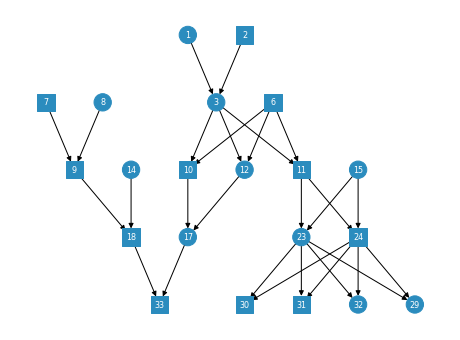

In [2]:
test_ped = Pedigree.simulate_from_founders_with_sex(2, 4, 2)
test_ped.draw()

In [4]:
h_graph = test_ped.get_haplotype_graph()

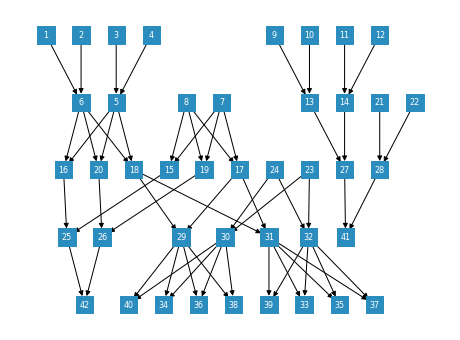

In [5]:
h_graph.draw()

In [6]:
h_graph.kinship().toarray()

> inferring depth 2020-08-14 22:48:58.137138
> sorting nodes 2020-08-14 22:48:58.137543
> backward pass 2020-08-14 22:48:58.137586
> forward pass 2020-08-14 22:48:58.137809


array([[0.5    , 0.     , 0.25   , 0.     , 0.     , 0.     , 0.     ,
        0.125  , 0.125  , 0.125  , 0.     , 0.     , 0.125  , 0.     ,
        0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.03125],
       [0.     , 0.5    , 0.25   , 0.     , 0.     , 0.     , 0.     ,
        0.125  , 0.125  , 0.125  , 0.     , 0.     , 0.125  , 0.     ,
        0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.0625 , 0.03125],
       [0.25   , 0.25   , 0.5    , 0.     , 0.     , 0.     , 0.     ,
        0.25   , 0.25   , 0.25   , 0.     , 0.     , 0.25   , 0.     ,
        0.125  , 0.125  , 0.125  , 0.125  , 0.125  , 0.125  , 0.0625 ],
       [0.     , 0.     , 0.     , 0.5    , 0.     , 0.     , 0.     ,
        0.25   , 0.25   , 0.25   , 0.     , 0.     , 0.25   , 0.     ,
        0.125  , 0.125  , 0.125  , 0.125  , 0.125  , 0.125  , 0.0625 ],
       [0.     , 0.     , 0.     , 0.     , 0.5    , 0.     , 0.25   ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.125  ,
  

In [56]:
kin = h_graph.kinship(individual_level=False).toarray()
kin_dok = h_graph.kinship_dok(individual_level=False).toarray()
kin, kin_dok

> inferring depth 2020-08-15 02:01:08.045098
> sorting nodes 2020-08-15 02:01:08.045467
> backward pass 2020-08-15 02:01:08.045503
> forward pass 2020-08-15 02:01:08.045747
> inferring depth 2020-08-15 02:01:08.048354
> sorting nodes 2020-08-15 02:01:08.048563
> backward pass 2020-08-15 02:01:08.048605
> forward pass 2020-08-15 02:01:08.089233
- - - > 24
Node: 24 : : : [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.5  0.5  0.25 0.25 0.25 0.25 0.  ]]
- - - > 23
Node: 23 : : : [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.5  0.5  0.25 0.25 0.25 0.25 0.  ]]
- - - > 22
Node: 22 : : : [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.
  0.   0

  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
before (Step 1): [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.5 0.  0.  0.  0.  0. ]]
Node: 35 : : : [[0.0625 0.0625 0.125  0.125  0.     0.     0.     0.125  0.25   0.125
  0.     0.25   0.125  0.     0.25   0.5    0.5    1.     0.5    0.5
  0.     0.0625 0.0625 0.125  0.125  0.     0.     0.     0.125  0.25
  0.125  0.     0.25   0.125  0.     0.25   0.5    0.25   0.25   0.25
  0.25   0.125 ]]
- - - > 33
before (Step 0): [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
before (Step 1): [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.5 0.  0.  0.  0.  0. ]]
Node: 33 : : : [[0.0625 0.0625 0.125  0.125  0.     0.     0.     0.125  0.25   0.125
 

(array([[1.    , 0.    , 0.    , ..., 0.0625, 0.0625, 0.0625],
        [0.    , 1.    , 0.5   , ..., 0.0625, 0.0625, 0.0625],
        [0.    , 0.5   , 1.    , ..., 0.125 , 0.125 , 0.125 ],
        ...,
        [0.0625, 0.0625, 0.125 , ..., 1.    , 0.5   , 0.0625],
        [0.0625, 0.0625, 0.125 , ..., 0.5   , 1.    , 0.0625],
        [0.125 , 0.125 , 0.25  , ..., 0.125 , 0.125 , 1.    ]]),
 array([[1.    , 0.    , 0.    , ..., 0.0625, 0.0625, 0.125 ],
        [0.    , 1.    , 0.5   , ..., 0.0625, 0.0625, 0.125 ],
        [0.    , 0.5   , 1.    , ..., 0.125 , 0.125 , 0.25  ],
        ...,
        [0.0625, 0.0625, 0.125 , ..., 1.    , 0.5   , 0.125 ],
        [0.0625, 0.0625, 0.125 , ..., 0.5   , 1.    , 0.125 ],
        [0.125 , 0.125 , 0.25  , ..., 0.125 , 0.125 , 1.    ]],
       dtype=float32))

In [54]:
kin_dok[(kin_dok - kin_dok.T).nonzero()], kin_dok.T[(kin_dok.T - kin_dok).nonzero()]

(array([0.25 , 0.25 , 0.25 , 0.25 , 0.375, 0.375, 0.375, 0.375],
       dtype=float32),
 array([0.375, 0.375, 0.375, 0.375, 0.25 , 0.25 , 0.25 , 0.25 ],
       dtype=float32))

In [55]:
rows, cols = (kin_dok - kin_dok.T).nonzero()
print(rows, cols)
np.array(h_graph.nodes)[rows], np.array(h_graph.nodes)[cols]

[ 7  9 28 30 41 41 41 41] [41 41 41 41  7  9 28 30]


(array([15, 19, 16, 20, 42, 42, 42, 42]),
 array([42, 42, 42, 42, 15, 19, 16, 20]))

In [33]:
kin_dok[7, 41], kin_dok[41, 7]

(0.25, 0.375)

In [23]:
bk_kin_dok = h_graph.kinship_dok(individual_level=False, backward_only=True).toarray()
bk_kin_dok[7, 41], bk_kin_dok[41, 7]

> inferring depth 2020-08-14 23:18:40.780216
> sorting nodes 2020-08-14 23:18:40.780563
> backward pass 2020-08-14 23:18:40.780599


(0.25, 0.0)

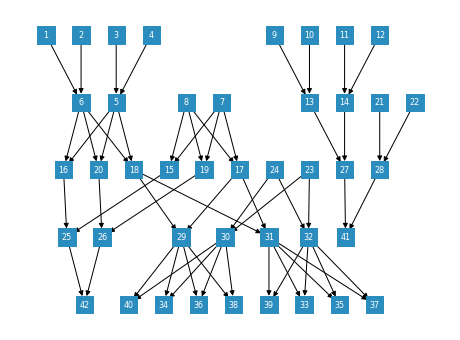

In [27]:
h_graph.draw()

In [39]:
np.allclose(test_ped.kinship_lange()[0], h_graph.kinship_dok().toarray())

100%|██████████| 21/21 [00:00<00:00, 6792.13it/s]

> inferring depth 2020-08-15 00:14:05.052440
> sorting nodes 2020-08-15 00:14:05.052718
> backward pass 2020-08-15 00:14:05.052786
> forward pass 2020-08-15 00:14:05.096772


False

In [40]:
test_ped.kinship_lange()[0], h_graph.kinship_dok().toarray()

100%|██████████| 21/21 [00:00<00:00, 7832.85it/s]

> inferring depth 2020-08-15 00:14:19.938968
> sorting nodes 2020-08-15 00:14:19.939167
> backward pass 2020-08-15 00:14:19.939202
> forward pass 2020-08-15 00:14:19.978873


(array([[0.5   , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.25  ,
         0.    , 0.125 , 0.125 , 0.125 , 0.    , 0.125 , 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.    , 0.5   , 0.    , 0.    , 0.    , 0.    , 0.    , 0.25  ,
         0.    , 0.125 , 0.125 , 0.125 , 0.    , 0.125 , 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625],
        [0.    , 0.    , 0.5   , 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.25  , 0.25  , 0.25  , 0.    , 0.25  , 0.125 , 0.125 ,
         0.125 , 0.125 , 0.125 , 0.125 , 0.125 ],
        [0.    , 0.    , 0.    , 0.5   , 0.    , 0.    , 0.    , 0.    ,
         0.25  , 0.    , 0.    , 0.    , 0.125 , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.0625],
        [0.    , 0.    , 0.    , 0.    , 0.5   , 0.    , 0.    , 0.    ,
         0.25  , 0.    , 0.    , 0.    , 0.125 , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.0625],
        [0.    , 0. 

In [43]:
2.*0.1875

0.375

In [44]:
h_graph.nodes

NodeView((1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42))

In [46]:
pd.DataFrame(h_graph.kinship_dok(individual_level=False, backward_only=True).toarray(),
             index=h_graph.nodes,
             columns=h_graph.nodes).sort_index().sort_index(axis=1)

> inferring depth 2020-08-15 01:04:09.414374
> sorting nodes 2020-08-15 01:04:09.414849
> backward pass 2020-08-15 01:04:09.414893


,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
1,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.000,0.125
2,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.000,0.125
3,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.000,0.125
4,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.000,0.125
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.000,0.250
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.000,0.250
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.000,0.250
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.000,0.250
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.125,0.000
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.125,0.000


In [47]:
.125*4

0.5

In [49]:
1./8

0.125

In [58]:
np.mean([0.5, 0.25])

0.375

In [123]:
kin = h_graph.kinship(individual_level=False).toarray()
(kin - kin.T).nonzero()

> inferring depth 2020-08-18 22:30:35.670674
> sorting nodes 2020-08-18 22:30:35.671016
> backward pass 2020-08-18 22:30:35.671065
> forward pass 2020-08-18 22:30:35.671426
Before ---> 32 <---> {32: 1.0, 33: 0.5, 35: 0.5, 37: 0.5, 39: 0.5}
After ---> 32 <---> {32: 0.5, 33: 0.25, 35: 0.25, 37: 0.25, 39: 0.25, 34: 0.25, 36: 0.25, 38: 0.25, 40: 0.25, 23: 0.5, 30: 0.5, 24: 0.5}
Before ---> 30 <---> {30: 1.0, 34: 0.5, 36: 0.5, 38: 0.5, 40: 0.5}
After ---> 30 <---> {30: 0.5, 34: 0.25, 36: 0.25, 38: 0.25, 40: 0.25, 32: 0.5, 33: 0.25, 35: 0.25, 37: 0.25, 39: 0.25, 23: 0.5, 24: 0.5}
Before ---> 28 <---> {28: 1.0, 41: 0.5}
After ---> 28 <---> {28: 0.5, 41: 0.25, 21: 0.5, 22: 0.5}
Before ---> 14 <---> {14: 1.0, 27: 0.5, 41: 0.25}
After ---> 14 <---> {14: 0.5, 27: 0.25, 41: 0.125, 11: 0.5, 12: 0.5}
Before ---> 13 <---> {13: 1.0, 27: 0.5, 41: 0.25}
After ---> 13 <---> {13: 0.5, 27: 0.25, 41: 0.125, 9: 0.5, 10: 0.5}
Before ---> 19 <---> {19: 1.0, 26: 0.5, 42: 0.25}
After ---> 19 <---> {19: 0.5, 26: 

(array([], dtype=int64), array([], dtype=int64))

In [125]:
kin[7, 41], kin[41, 7]

(0.375, 0.375)

In [69]:
kin[7, 41], kin[41, 7]

(0.25, 0.375)

In [118]:
kin_dict = h_graph.kinship(individual_level=False, to_csr=False)
kin_dict[7], kin_dict[8], kin_dict[19], kin_dict[25], kin_dict[26], kin_dict[42]

> inferring depth 2020-08-16 16:30:47.962008
> sorting nodes 2020-08-16 16:30:47.962362
> backward pass 2020-08-16 16:30:47.962416
> forward pass 2020-08-16 16:30:47.962770


({7: 1.0,
  15: 0.5,
  25: 0.25,
  42: 0.25,
  17: 0.5,
  29: 0.25,
  34: 0.125,
  36: 0.125,
  38: 0.125,
  40: 0.125,
  31: 0.25,
  33: 0.125,
  35: 0.125,
  37: 0.125,
  39: 0.125,
  19: 0.5,
  26: 0.25},
 {8: 1.0,
  15: 0.5,
  25: 0.25,
  42: 0.25,
  17: 0.5,
  29: 0.25,
  34: 0.125,
  36: 0.125,
  38: 0.125,
  40: 0.125,
  31: 0.25,
  33: 0.125,
  35: 0.125,
  37: 0.125,
  39: 0.125,
  19: 0.5,
  26: 0.25},
 {19: 1.0,
  26: 0.5,
  42: 0.25,
  7: 0.5,
  15: 0.5,
  17: 0.5,
  25: 0.25,
  29: 0.25,
  31: 0.25,
  33: 0.125,
  34: 0.125,
  35: 0.125,
  36: 0.125,
  37: 0.125,
  38: 0.125,
  39: 0.125,
  40: 0.125,
  8: 0.5},
 {25: 1.0,
  42: 0.5,
  7: 0.25,
  8: 0.25,
  15: 0.5,
  17: 0.25,
  19: 0.25,
  26: 0.25,
  29: 0.25,
  31: 0.25,
  33: 0.125,
  34: 0.125,
  35: 0.125,
  36: 0.125,
  37: 0.125,
  38: 0.125,
  39: 0.125,
  40: 0.125,
  1: 0.125,
  2: 0.125,
  3: 0.125,
  4: 0.125,
  5: 0.25,
  6: 0.25,
  16: 0.5,
  18: 0.25,
  20: 0.25},
 {26: 1.0,
  42: 0.5,
  7: 0.25,
  8: 0.25

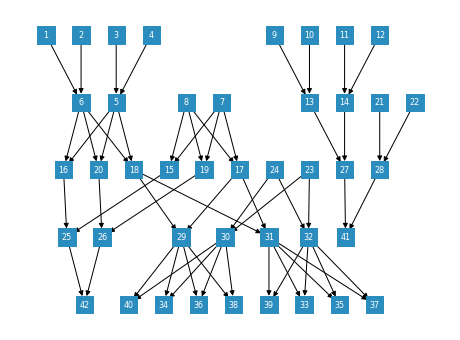

In [74]:
h_graph.draw()

In [121]:
3./8

0.375

In [122]:
msg_kin = pd.DataFrame(h_graph.kinship().toarray(),
             index=test_ped.nodes,
             columns=test_ped.nodes).sort_index().sort_index(axis=1)
msg_kin

> inferring depth 2020-08-18 22:29:23.282713
> sorting nodes 2020-08-18 22:29:23.286810
> backward pass 2020-08-18 22:29:23.286906
> forward pass 2020-08-18 22:29:23.287523
Before ---> 32 <---> {32: 1.0, 33: 0.5, 35: 0.5, 37: 0.5, 39: 0.5}
After ---> 32 <---> {32: 0.5, 33: 0.25, 35: 0.25, 37: 0.25, 39: 0.25, 34: 0.25, 36: 0.25, 38: 0.25, 40: 0.25, 23: 0.5, 30: 0.5, 24: 0.5}
Before ---> 30 <---> {30: 1.0, 34: 0.5, 36: 0.5, 38: 0.5, 40: 0.5}
After ---> 30 <---> {30: 0.5, 34: 0.25, 36: 0.25, 38: 0.25, 40: 0.25, 32: 0.5, 33: 0.25, 35: 0.25, 37: 0.25, 39: 0.25, 23: 0.5, 24: 0.5}
Before ---> 28 <---> {28: 1.0, 41: 0.5}
After ---> 28 <---> {28: 0.5, 41: 0.25, 21: 0.5, 22: 0.5}
Before ---> 14 <---> {14: 1.0, 27: 0.5, 41: 0.25}
After ---> 14 <---> {14: 0.5, 27: 0.25, 41: 0.125, 11: 0.5, 12: 0.5}
Before ---> 13 <---> {13: 1.0, 27: 0.5, 41: 0.25}
After ---> 13 <---> {13: 0.5, 27: 0.25, 41: 0.125, 9: 0.5, 10: 0.5}
Before ---> 19 <---> {19: 1.0, 26: 0.5, 42: 0.25}
After ---> 19 <---> {19: 0.5, 26: 

,1,2,3,6,7,8,9,10,11,12,...,15,17,18,23,24,29,30,31,32,33
1,0.5000,0.0000,0.250,0.000,0.0000,0.0000,0.000,0.1250,0.1250,0.1250,...,0.00,0.12500,0.0000,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.06250
2,0.0000,0.5000,0.250,0.000,0.0000,0.0000,0.000,0.1250,0.1250,0.1250,...,0.00,0.12500,0.0000,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.06250
3,0.2500,0.2500,0.250,0.000,0.0000,0.0000,0.000,0.2500,0.2500,0.2500,...,0.00,0.25000,0.0000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.12500
6,0.0000,0.0000,0.000,0.500,0.0000,0.0000,0.000,0.2500,0.2500,0.2500,...,0.00,0.25000,0.0000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.12500
7,0.0000,0.0000,0.000,0.000,0.5000,0.0000,0.250,0.0000,0.0000,0.0000,...,0.00,0.00000,0.1250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.06250
8,0.0000,0.0000,0.000,0.000,0.0000,0.5000,0.250,0.0000,0.0000,0.0000,...,0.00,0.00000,0.1250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.06250
9,0.0000,0.0000,0.000,0.000,0.2500,0.2500,0.250,0.0000,0.0000,0.0000,...,0.00,0.00000,0.2500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.12500
10,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.1875,0.2500,0.2500,...,0.00,0.37500,0.0000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.18750
11,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.2500,0.1875,0.2500,...,0.00,0.25000,0.0000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.12500
12,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.2500,0.2500,0.1875,...,0.00,0.37500,0.0000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.18750


In [108]:
kin_lange = test_ped.kinship_lange()
kin_lange_df = pd.DataFrame(kin_lange[0], index=kin_lange[1], columns=kin_lange[1]).sort_index().sort_index(axis=1)
kin_lange_df

100%|██████████| 21/21 [00:00<00:00, 6802.62it/s]


,1,2,3,6,7,8,9,10,11,12,...,15,17,18,23,24,29,30,31,32,33
1,0.5000,0.0000,0.250,0.000,0.0000,0.0000,0.000,0.1250,0.125,0.1250,...,0.00,0.1250,0.000,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625
2,0.0000,0.5000,0.250,0.000,0.0000,0.0000,0.000,0.1250,0.125,0.1250,...,0.00,0.1250,0.000,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625
3,0.2500,0.2500,0.500,0.000,0.0000,0.0000,0.000,0.2500,0.250,0.2500,...,0.00,0.2500,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250
6,0.0000,0.0000,0.000,0.500,0.0000,0.0000,0.000,0.2500,0.250,0.2500,...,0.00,0.2500,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250
7,0.0000,0.0000,0.000,0.000,0.5000,0.0000,0.250,0.0000,0.000,0.0000,...,0.00,0.0000,0.125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0625
8,0.0000,0.0000,0.000,0.000,0.0000,0.5000,0.250,0.0000,0.000,0.0000,...,0.00,0.0000,0.125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0625
9,0.0000,0.0000,0.000,0.000,0.2500,0.2500,0.500,0.0000,0.000,0.0000,...,0.00,0.0000,0.250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1250
10,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.5000,0.250,0.2500,...,0.00,0.3750,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1875
11,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.2500,0.500,0.2500,...,0.00,0.2500,0.000,0.2500,0.2500,0.2500,0.2500,0.2500,0.2500,0.1250
12,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.2500,0.250,0.5000,...,0.00,0.3750,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1875


In [85]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
kinship2 = importr('kinship2')

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()



In [105]:
ped_table = test_ped.to_table()
r_ped = kinship2.pedigree(ped_table['individual'].values, ped_table['father'].values, ped_table['mother'].values,
                 ped_table['sex'].values)
res = kinship2.kinship(r_ped)
r_kin = pd.DataFrame(np.asarray(res), index=np.asarray(res.colnames).astype(int), columns=np.asarray(res.colnames).astype(int)).sort_index().sort_index(axis=1)

r_kin

,1,2,3,6,7,8,9,10,11,12,...,15,17,18,23,24,29,30,31,32,33
1,0.5000,0.0000,0.250,0.000,0.0000,0.0000,0.000,0.1250,0.125,0.1250,...,0.00,0.1250,0.000,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625
2,0.0000,0.5000,0.250,0.000,0.0000,0.0000,0.000,0.1250,0.125,0.1250,...,0.00,0.1250,0.000,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625
3,0.2500,0.2500,0.500,0.000,0.0000,0.0000,0.000,0.2500,0.250,0.2500,...,0.00,0.2500,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250
6,0.0000,0.0000,0.000,0.500,0.0000,0.0000,0.000,0.2500,0.250,0.2500,...,0.00,0.2500,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250
7,0.0000,0.0000,0.000,0.000,0.5000,0.0000,0.250,0.0000,0.000,0.0000,...,0.00,0.0000,0.125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0625
8,0.0000,0.0000,0.000,0.000,0.0000,0.5000,0.250,0.0000,0.000,0.0000,...,0.00,0.0000,0.125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0625
9,0.0000,0.0000,0.000,0.000,0.2500,0.2500,0.500,0.0000,0.000,0.0000,...,0.00,0.0000,0.250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1250
10,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.5000,0.250,0.2500,...,0.00,0.3750,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1875
11,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.2500,0.500,0.2500,...,0.00,0.2500,0.000,0.2500,0.2500,0.2500,0.2500,0.2500,0.2500,0.1250
12,0.1250,0.1250,0.250,0.250,0.0000,0.0000,0.000,0.2500,0.250,0.5000,...,0.00,0.3750,0.000,0.1250,0.1250,0.1250,0.1250,0.1250,0.1250,0.1875


In [113]:
np.allclose(msg_kin.values, r_kin.values)

False

In [116]:
rows, cols = (msg_kin.values - r_kin.values).nonzero()
np.array(test_ped.nodes)[rows], np.array(test_ped.nodes)[cols]

(array([10, 12, 17, 33, 33, 33]), array([33, 33, 33, 10, 12, 17]))

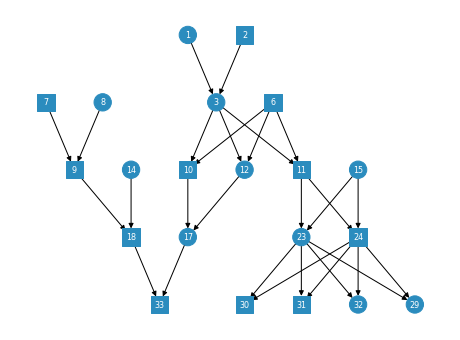

In [115]:
test_ped.draw()

In [117]:
h_graph.ind_to_hap

{1: [1, 2],
 2: [3, 4],
 3: [5, 6],
 6: [7, 8],
 7: [9, 10],
 8: [11, 12],
 9: [13, 14],
 10: [15, 16],
 11: [17, 18],
 12: [19, 20],
 14: [21, 22],
 15: [23, 24],
 17: [25, 26],
 18: [27, 28],
 23: [29, 30],
 24: [31, 32],
 29: [33, 34],
 30: [35, 36],
 31: [37, 38],
 32: [39, 40],
 33: [41, 42]}

In [131]:
x = np.random.normal(size=(100, 1))
np.dot(x.T, x)

array([[102.22619175]])

In [133]:
np.trace(np.dot(x, x.T))

102.22619174542567